In [1]:
%pip install patchify

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/computerVisionProject

/content/drive/MyDrive/computerVisionProject


In [4]:
!python3 train_image_preprocessing.py

100% 132/132 [01:14<00:00,  1.78it/s]
100% 132/132 [05:54<00:00,  2.69s/it]


In [5]:
!python3 test_image_preprocessing.py

100% 16/16 [00:14<00:00,  1.12it/s]
100% 16/16 [00:52<00:00,  3.26s/it]


In [6]:
import os
import cv2
import math
import numpy as np
from matplotlib import pyplot
from tqdm import tqdm
import random
from matplotlib.patches import Circle
from tensorflow.keras.utils import *
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

In [7]:
x_path = 'dataSets/preprocessed/trainpatches/MA/x'
y_path = 'dataSets/preprocessed/trainpatches/MA/y'
x_N_path = 'dataSets/preprocessed/trainpatches/NonMA/x'
y_N_path = 'dataSets/preprocessed/trainpatches/NonMA/y'
x_lst = os.listdir(x_path)
y_lst = os.listdir(y_path)
x_N_lst = os.listdir(x_N_path)
y_N_lst = os.listdir(y_N_path)

In [8]:
x = []
y = []
for i in tqdm(x_lst):
    x_im_path = x_path+'/'+i
    y_im_path = y_path+'/'+i
    x_read = cv2.imread(x_im_path,cv2.IMREAD_UNCHANGED)
    x_read = x_read/255
    y_read = cv2.imread(y_im_path,cv2.IMREAD_UNCHANGED)
    y_read = y_read/255
    y_th_val,y_th = cv2.threshold(y_read,0.3,1,cv2.THRESH_BINARY)
    x_read = np.expand_dims(x_read,axis=-1)
    y_read = np.expand_dims(y_th,axis=-1)
    x.append(x_read)
    y.append(y_read)

100%|██████████| 1183/1183 [00:08<00:00, 142.66it/s]


In [9]:
for i in tqdm(range(len(x_lst))):
    a = random.randint(0,len(x_N_lst)-1)
    x_im_N_path = x_N_path+'/'+x_N_lst[a]
    y_im_N_path = y_N_path+'/'+y_N_lst[a]
    x_N_read = cv2.imread(x_im_N_path,cv2.IMREAD_UNCHANGED)
    x_N_read = x_N_read/255
    y_N_read = cv2.imread(y_im_N_path,cv2.IMREAD_UNCHANGED)
    y_N_read = y_N_read/255
    y_th_N_val,y_th_N = cv2.threshold(y_N_read,0.3,1,cv2.THRESH_BINARY)
    x_N_read = np.expand_dims(x_N_read,axis=-1)
    y_N_read = np.expand_dims(y_th_N,axis=-1)
    x.append(x_N_read)
    y.append(y_N_read)

100%|██████████| 1183/1183 [00:07<00:00, 161.17it/s]


In [10]:
x = np.array(x,dtype='float32')
y = np.array(y,dtype='float32')

x = np.array(x)
y = np.array(y)

In [11]:
def attention_block(x,gating,channel):

    # x = x[0]
    theta_x = Conv2D(channel, kernel_size=(1,1), strides=(2,2), padding='same')(x)
    phi_g = Conv2D(channel, kernel_size=(1,1), strides=(1,1), padding='same')(gating)
    add_x_g = add([theta_x, phi_g])
    act_xg = Activation('relu')(add_x_g)
    si = Conv2D(1, kernel_size=(1,1), padding='same')(act_xg)
    act_sig = Activation('sigmoid')(si)
    # si_up = UpSampling2D(size=(x.shape[1],x.shape[2]))(act_sig)
    si_up = Conv2DTranspose(channel, kernel_size=(1,1), padding='same', strides=(2,2))(act_sig)
    si_mul = multiply([si_up,x])
    result = Conv2D(x.shape[3], kernel_size=(1,1), padding='same')(si_mul)
    return result

In [12]:
def build_model(input_layer = (128,128,1), filters = 1):
    x_input = Input(input_layer)
    # print(type(x_input))

    #s = tf.keras.layers.Lambda(lambda x_input:x_input/255)(x_input)

    conv1 = Conv2D(filters * 1, (3, 3), activation="relu", padding="same")(x_input)
    conv1 = Dropout(0.25)(conv1)
    conv1 = Conv2D(filters * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(filters * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = Conv2D(filters * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    # Middle
    conv3 = Conv2D(filters * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(filters * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = Dropout(0.5)(conv3)



    deconv2 = Conv2DTranspose(filters * 2, (3, 3), strides=(2, 2), padding="same")(pool3)
    X_att = attention_block(conv2, pool3, (filters*2))
    uconv2 = subtract([X_att, deconv2])
    uconv2 = Conv2D(filters * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(filters * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(filters * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    X_att1 = attention_block(conv1, uconv2, (filters*1))
    uconv1 = subtract([X_att1, deconv1])
    uconv1 = Conv2D(filters * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(filters * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(2, (3,3), activation="relu", padding="same")(uconv1)

    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

    model = Model(inputs= x_input, outputs= output_layer)

    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['dropout[0][0]']             
                                                                                              

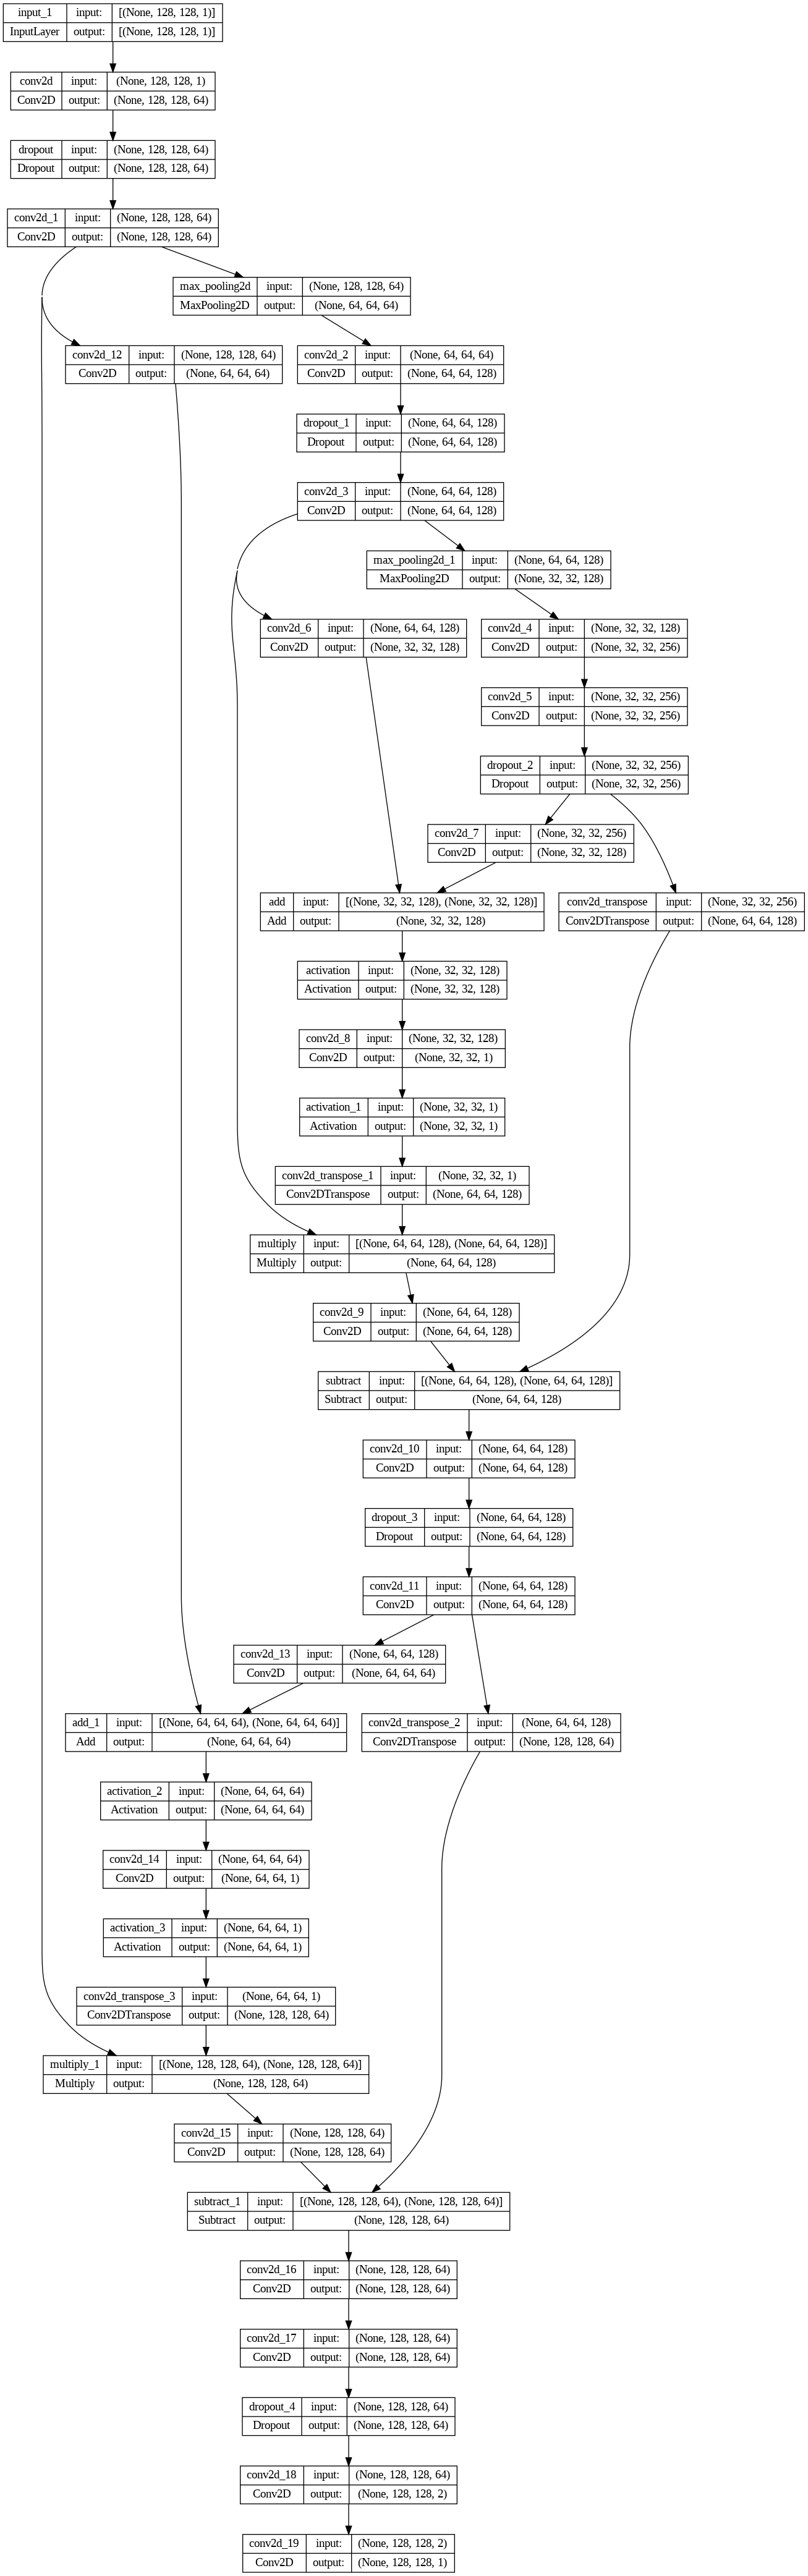

In [13]:
model = build_model((128,128,1),64)
model.summary()

plot_model(model, to_file='new_architecture.png', show_shapes=(True))


In [14]:
def specificity(y_pred, y_true):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    neg_y_true = 1 - y_true_f
    neg_y_pred = 1 - y_pred_f
    fp = K.sum(neg_y_true * y_pred_f)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

In [15]:
def sensitivity(y_pred,y_true):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    neg_y_true = 1 - y_true_f
    neg_y_pred = 1 - y_pred_f
    tp = K.sum(y_true_f*y_pred_f)
    fn = K.sum(y_true_f*neg_y_pred)
    return tp / (tp+fn+K.epsilon())

In [16]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(y_true,-1) + K.sum(y_pred,-1) + smooth)

In [17]:
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [18]:
alpha=0.25
gamma=2


def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)

    return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b


def focal_loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))

    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)

    return tf.reduce_mean(loss)

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)


def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999)


In [20]:
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=[specificity, sensitivity])

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 42,shuffle=True)

In [22]:
history = model.fit(x=x_train,y=y_train,epochs=100,validation_data=(x_test,y_test))

Epoch 1/100
67/67 [==============================] - 54s 442ms/step - loss: 0.3630 - specificity: 0.9960 - sensitivity: 0.0021 - val_loss: 0.0662 - val_specificity: 0.9957 - val_sensitivity: 0.0014
Epoch 2/100
67/67 [==============================] - 24s 363ms/step - loss: 0.0475 - specificity: 0.9961 - sensitivity: 0.0014 - val_loss: 0.1549 - val_specificity: 0.9960 - val_sensitivity: 0.0051
Epoch 3/100
67/67 [==============================] - 25s 367ms/step - loss: 0.0298 - specificity: 0.9961 - sensitivity: 0.0049 - val_loss: 0.1630 - val_specificity: 0.9962 - val_sensitivity: 0.0061
Epoch 4/100
67/67 [==============================] - 25s 369ms/step - loss: 0.0265 - specificity: 0.9961 - sensitivity: 0.0068 - val_loss: 0.1547 - val_specificity: 0.9962 - val_sensitivity: 0.0065
Epoch 5/100
67/67 [==============================] - 25s 373ms/step - loss: 0.0258 - specificity: 0.9961 - sensitivity: 0.0071 - val_loss: 0.1549 - val_specificity: 0.9962 - val_sensitivity: 0.0066
Epoch 6/10

In [23]:
model.save('attention_Sub_UNet_binary_cross_entropy_ttt_400_epoch.h5')
model.save('attention_Sub_UNet_binary_cross_entropy_ttt_400_epoch.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
print(history.history.keys())

dict_keys(['loss', 'specificity', 'sensitivity', 'val_loss', 'val_specificity', 'val_sensitivity'])


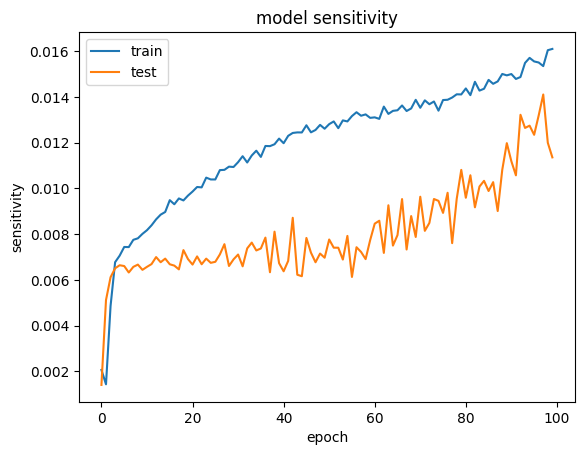

In [25]:
pyplot.plot(history.history['sensitivity'])
pyplot.plot(history.history['val_sensitivity'])
pyplot.title('model sensitivity')
pyplot.ylabel('sensitivity')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

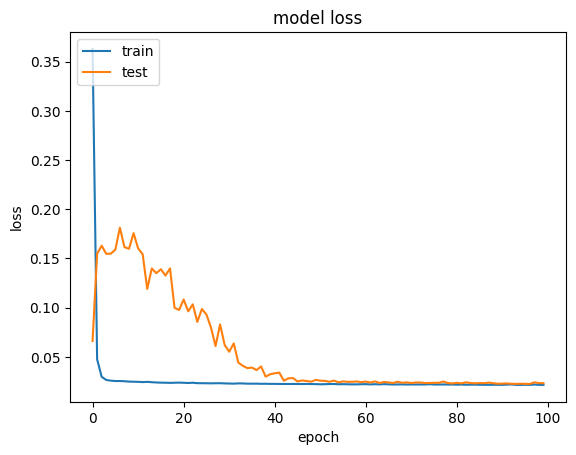

In [26]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()